In [64]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam, SGD, Adagrad, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, Callback
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore', category=DeprecationWarning)
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix

#### Preprocessing

In [2]:
train, test = [], []
z_train, z_test = [], []
chars =  ['a', 'bA', 'dA', 'lA', 'tA']

def normalize(seq):
    min_x, max_x = min(el[0] for el in seq), max(el[0] for el in seq)
    min_y, max_y = min(el[1] for el in seq), max(el[1] for el in seq)
    for el in seq:
        el[0] = (el[0] - min_x)/(max_x-min_x)
        el[1] = (el[1] - min_y)/(max_y-min_y)
    return seq

def read_ip(path):
    seq = []
    with open(path, 'r') as file:
        contents = file.read()
        items = contents.split()
        for i in range(1,len(items),2):
            seq.append([float(items[i]),float(items[i+1])])
        # train.append(normalize(seq))
    return normalize(seq)

for ch in chars:
    for f in os.listdir("data/Handwriting_Data/" + str(ch)+"/train"):
        train.append(read_ip("data/Handwriting_Data/" + str(ch)+"/train/" + str(f)))
        z_train.append(str(ch))
    for f in os.listdir("data/Handwriting_Data/" + str(ch)+"/dev"):
        test.append(read_ip("data/Handwriting_Data/" + str(ch) + "/dev/" + str(f)))
        z_test.append(str(ch))

In [3]:
label_map = {'a':0, 'bA':1, 'dA':2, 'lA':3, 'tA':4}
z_train_onehot = tf.keras.utils.to_categorical([label_map[x] for x in z_train], 5)
z_test_onehot = tf.keras.utils.to_categorical([label_map[x] for x in z_test], 5)

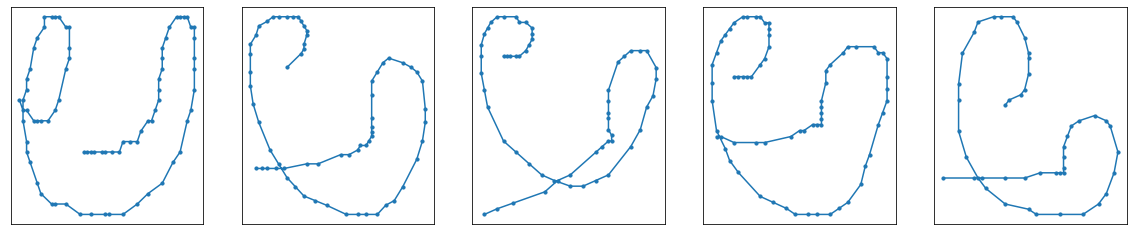

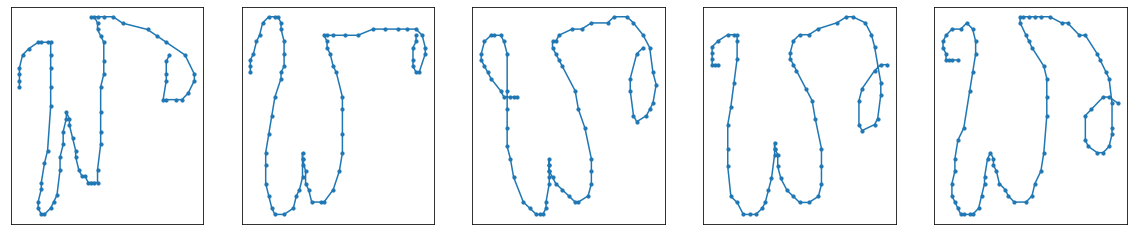

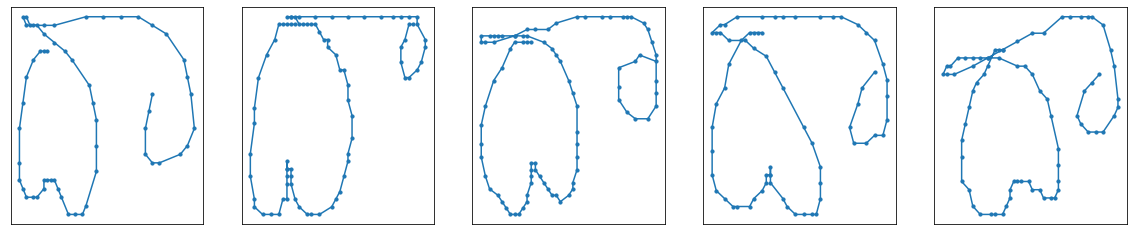

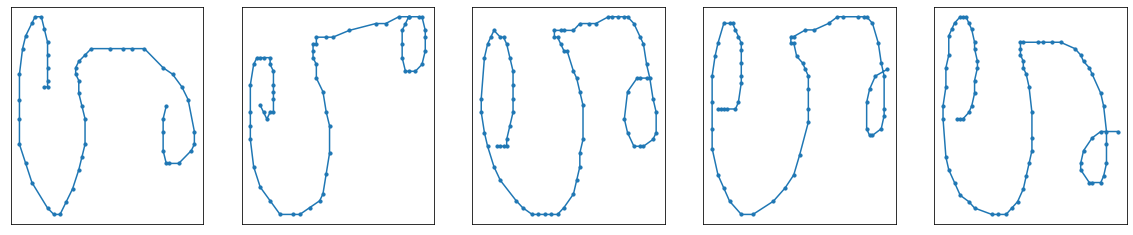

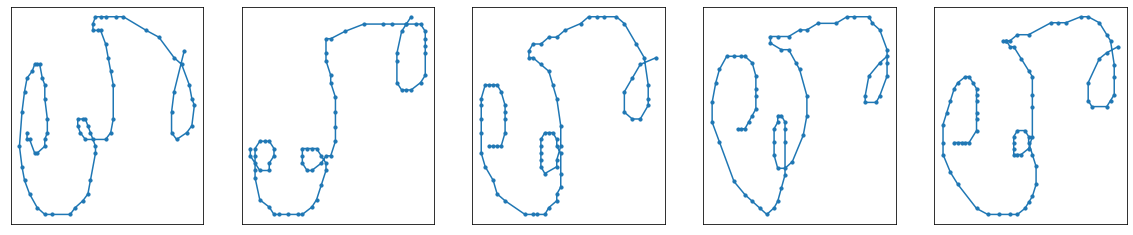

In [49]:
for c in chars:
    fig, ax = plt.subplots(1, 5, figsize=(20, 4))
    for i in range(5):
        char_data = np.array(train[z_train.index(c)+i])
        ax[i].plot(char_data[:, 0], char_data[:, 1])
        ax[i].scatter(char_data[:, 0], char_data[:, 1], s=10)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.show()

#### RNN Model

In [4]:
rnn_model_archs = [
    
    [SimpleRNN(64, activation="tanh", batch_input_shape=(None, None, 2), return_sequences=False),
    Dense(5, activation="softmax")],
    
    [SimpleRNN(128, activation="tanh", batch_input_shape=(None, None, 2), return_sequences=False),
    Dense(64, activation="tanh"),
    Dense(5, activation="softmax")],
    
    [SimpleRNN(128, activation="tanh", batch_input_shape=(None, None, 2), return_sequences=True),
    SimpleRNN(96, activation="tanh", return_sequences=False),
    Dense(96, activation="tanh"),
    Dense(5, activation="softmax")],
    
    [SimpleRNN(256, activation="tanh", batch_input_shape=(None, None, 2), return_sequences=True),
    SimpleRNN(128, activation="tanh", return_sequences=False),
    Dense(128, activation="tanh"),
    Dense(5, activation="softmax")],
    
    [SimpleRNN(256, activation="tanh", batch_input_shape=(None, None, 2), return_sequences=True),
    SimpleRNN(128, activation="tanh", return_sequences=True),
    SimpleRNN(128, activation="tanh", return_sequences=False),
    Dense(128, activation="tanh"),
    Dense(5, activation="softmax")],
    
    [SimpleRNN(256, activation="tanh", batch_input_shape=(None, None, 2), return_sequences=True),
    SimpleRNN(256, activation="tanh", return_sequences=True),
    SimpleRNN(128, activation="tanh", return_sequences=False),
    Dense(128, activation="tanh"),
    Dense(5, activation="softmax")]
    
#     [SimpleRNN(256, activation="tanh", batch_input_shape=(None, None, 2), return_sequences=True),
#     SimpleRNN(256, activation="tanh", return_sequences=True),
#     SimpleRNN(128, activation="tanh", return_sequences=True),
#     SimpleRNN(128, activation="tanh", return_sequences=False),
#     Dense(256, activation="tanh"),
#     Dense(128, activation="tanh"),
#     Dense(5, activation="softmax")],
    
#     [SimpleRNN(256, activation="tanh", batch_input_shape=(None, None, 2), return_sequences=True),
#     SimpleRNN(256, activation="tanh", return_sequences=True),
#     SimpleRNN(128, activation="tanh", return_sequences=True),
#     SimpleRNN(128, activation="tanh", return_sequences=False),
#     Dense(256, activation="tanh"),
#     Dense(256, activation="tanh"),
#     Dense(128, activation="tanh"),
#     Dense(5, activation="softmax")],
]

In [5]:
my_tensor = tf.ragged.constant(train)
test_tensor = tf.ragged.constant(test)

for i in range(len(rnn_model_archs)):
    model = Sequential(rnn_model_archs[i])
    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(loss="categorical_crossentropy", optimizer=adam_optimizer, metrics=['accuracy']) 

    # Train the model
    my_callbacks = [ EarlyStopping(monitor='loss', min_delta=1e-4, patience=10),    
                    TensorBoard(log_dir=f'./logdir/Q1/rnn/arch_{i+1}')]

    model_fit = model.fit(my_tensor, 
                          z_train_onehot, 
                          batch_size=len(train),
                          epochs=10000, 
                          verbose=0,
                          validation_split=0.0,
                          callbacks=my_callbacks, 
                          shuffle=False, 
                          validation_batch_size=None)

    hist_metric = 'accuracy'
    print(f'epochs: {len(model_fit.history[hist_metric])}, acc: {model_fit.history[hist_metric][-1]}\n')
    model.save(f'models/Q1/rnn/arch_{i+1}.tf')

    loss, accuracy = model.evaluate(test_tensor,z_test_onehot)
    
    print(f"Test loss (arch {i+1}):", loss)
    print(f"Test accuracy (arch {i+1}):", accuracy)

epochs: 154, acc: 0.7163742780685425

INFO:tensorflow:Assets written to: models/Q1/rnn/arch_1.tf\assets
4/4 [==============================] - 0s 4ms/step - loss: 0.6063 - accuracy: 0.7800
Test loss (arch 1): 0.6063016057014465
Test accuracy (arch 1): 0.7799999713897705
epochs: 81, acc: 0.7105262875556946

INFO:tensorflow:Assets written to: models/Q1/rnn/arch_2.tf\assets
4/4 [==============================] - 0s 5ms/step - loss: 0.7600 - accuracy: 0.6100
Test loss (arch 2): 0.760026752948761
Test accuracy (arch 2): 0.6100000143051147
epochs: 99, acc: 0.8918128609657288

INFO:tensorflow:Assets written to: models/Q1/rnn/arch_3.tf\assets
4/4 [==============================] - 0s 12ms/step - loss: 0.1720 - accuracy: 0.9800
Test loss (arch 3): 0.17195986211299896
Test accuracy (arch 3): 0.9800000190734863
epochs: 73, acc: 0.6374269127845764

INFO:tensorflow:Assets written to: models/Q1/rnn/arch_4.tf\assets
4/4 [==============================] - 0s 21ms/step - loss: 0.6920 - accuracy: 0.7000

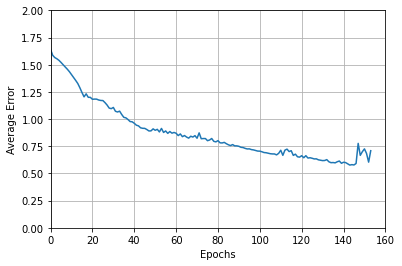

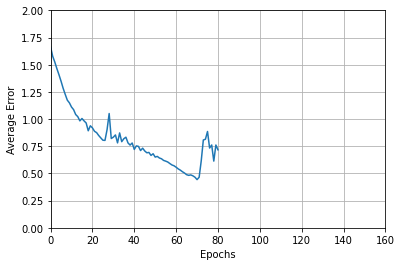

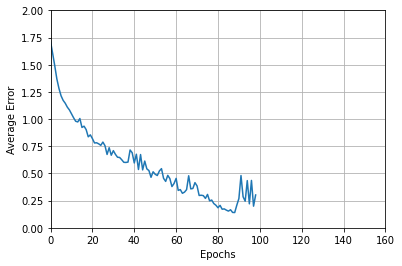

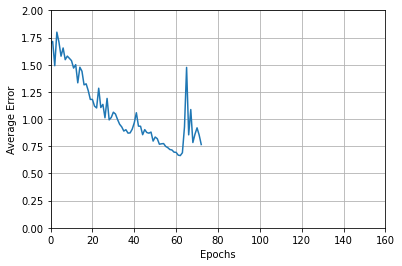

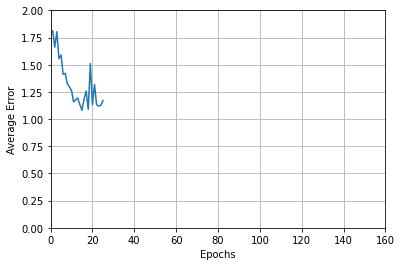

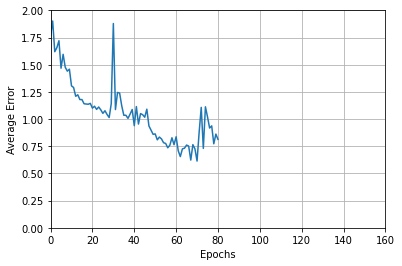

In [18]:

plot_path = 'plotdata/Q1'
for i in range(6):
    df = pd.read_csv(os.path.join(plot_path, f'rnn{i+1}.csv'), usecols=['Step', 'Value'])
    #plt.title(f'arch{i+1}')
    plt.plot(df.Step, df.Value)
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Average Error')
    plt.xlim([0, 160])
    plt.ylim([0, 2])
    plt.show()

In [53]:
print('RNN')
for i in range(len(rnn_model_archs)):
    model = tf.keras.models.load_model(f'models/Q1/rnn/arch_{i+1}.tf')
    _, acc = model.evaluate(my_tensor,z_train_onehot)   
    print('train acc:', acc)
    _, acc = model.evaluate(test_tensor,z_test_onehot)   
    print('test acc:', acc)
    print('\n\n')

RNN
11/11 [==============================] - 0s 5ms/step - loss: 0.6130 - accuracy: 0.7690
train acc: 0.7690058350563049
4/4 [==============================] - 0s 4ms/step - loss: 0.6063 - accuracy: 0.7800
test acc: 0.7799999713897705



11/11 [==============================] - 0s 12ms/step - loss: 0.8230 - accuracy: 0.6404
train acc: 0.640350878238678
4/4 [==============================] - 0s 9ms/step - loss: 0.7600 - accuracy: 0.6100
test acc: 0.6100000143051147



11/11 [==============================] - 1s 26ms/step - loss: 0.2029 - accuracy: 0.9444
train acc: 0.9444444179534912
4/4 [==============================] - 0s 17ms/step - loss: 0.1720 - accuracy: 0.9800
test acc: 0.9800000190734863



11/11 [==============================] - 1s 58ms/step - loss: 0.7921 - accuracy: 0.6784
train acc: 0.6783625483512878
4/4 [==============================] - 0s 34ms/step - loss: 0.6920 - accuracy: 0.7000
test acc: 0.699999988079071



11/11 [==============================] - 2s 78ms/step - l

4/4 [==============================] - 0s 17ms/step


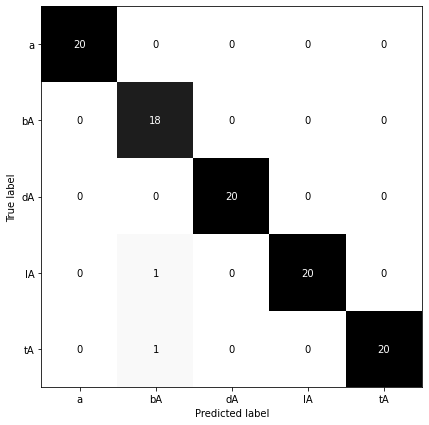

In [67]:
best_arch = 3
model = tf.keras.models.load_model(f'models/Q1/rnn/arch_{best_arch}.tf')
pred = np.argmax(model.predict(test_tensor), axis=1)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(pred, np.argmax(z_test_onehot, axis=1)), display_labels=chars)
cm_display.plot(ax = ax, cmap='Greys', colorbar=False)
plt.show()

#### LSTM Model

In [6]:
lstm_model_archs = [
    
    [LSTM(64, activation="tanh", batch_input_shape=(None, None, 2), return_sequences=False),
    Dense(5, activation="softmax")],
    
    [LSTM(128, activation="tanh", batch_input_shape=(None, None, 2), return_sequences=False),
    Dense(64, activation="tanh"),
    Dense(5, activation="softmax")],
    
    [LSTM(128, activation="tanh", batch_input_shape=(None, None, 2), return_sequences=True),
    LSTM(96, activation="tanh", return_sequences=False),
    Dense(96, activation="tanh"),
    Dense(5, activation="softmax")],
    
    [LSTM(256, activation="tanh", batch_input_shape=(None, None, 2), return_sequences=True),
    LSTM(128, activation="tanh", return_sequences=False),
    Dense(128, activation="tanh"),
    Dense(5, activation="softmax")],
    
    [LSTM(256, activation="tanh", batch_input_shape=(None, None, 2), return_sequences=True),
    LSTM(128, activation="tanh", return_sequences=True),
    LSTM(128, activation="tanh", return_sequences=False),
    Dense(128, activation="tanh"),
    Dense(5, activation="softmax")],
    
    [LSTM(256, activation="tanh", batch_input_shape=(None, None, 2), return_sequences=True),
    LSTM(256, activation="tanh", return_sequences=True),
    LSTM(128, activation="tanh", return_sequences=False),
    Dense(128, activation="tanh"),
    Dense(5, activation="softmax")]
    
#     [LSTM(256, activation="tanh", batch_input_shape=(None, None, 2), return_sequences=True),
#     LSTM(256, activation="tanh", return_sequences=True),
#     LSTM(128, activation="tanh", return_sequences=True),
#     LSTM(128, activation="tanh", return_sequences=False),
#     Dense(256, activation="tanh"),
#     Dense(128, activation="tanh"),
#     Dense(5, activation="softmax")],
    
#     [LSTM(256, activation="tanh", batch_input_shape=(None, None, 2), return_sequences=True),
#     LSTM(256, activation="tanh", return_sequences=True),
#     LSTM(128, activation="tanh", return_sequences=True),
#     LSTM(128, activation="tanh", return_sequences=False),
#     Dense(256, activation="tanh"),
#     Dense(256, activation="tanh"),
#     Dense(128, activation="tanh"),
#     Dense(5, activation="softmax")],
]

In [9]:
my_tensor = tf.ragged.constant(train)
test_tensor = tf.ragged.constant(test)

for i in range(3, len(lstm_model_archs)-2):
    model = Sequential(lstm_model_archs[i])
    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(loss="categorical_crossentropy", optimizer=adam_optimizer, metrics=['accuracy']) 

    # Train the model
    my_callbacks = [ EarlyStopping(monitor='loss', min_delta=1e-4, patience=10),    
                    TensorBoard(log_dir=f'./logdir/Q1/lstm/arch_{i+1}')]

    model_fit = model.fit(my_tensor, 
                          z_train_onehot, 
                          batch_size=len(train),
                          epochs=10000, 
                          verbose=0,
                          validation_split=0.0,
                          callbacks=my_callbacks, 
                          shuffle=False, 
                          validation_batch_size=None)

    hist_metric = 'accuracy'
    print(f'epochs: {len(model_fit.history[hist_metric])}, acc: {model_fit.history[hist_metric][-1]}\n')
    model.save(f'models/Q1/lstm/arch_{i+1}.tf')

    loss, accuracy = model.evaluate(test_tensor,z_test_onehot)
    
    print(f"Test loss (arch {i+1}):", loss)
    print(f"Test accuracy (arch {i+1}):", accuracy)

epochs: 53, acc: 0.7690058350563049



INFO:tensorflow:Assets written to: models/Q1/lstm/arch_4.tf\assets


INFO:tensorflow:Assets written to: models/Q1/lstm/arch_4.tf\assets


4/4 [==============================] - 1s 156ms/step - loss: 0.3827 - accuracy: 0.8600
Test loss (arch 4): 0.38268887996673584
Test accuracy (arch 4): 0.8600000143051147


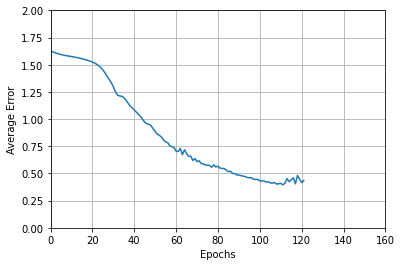

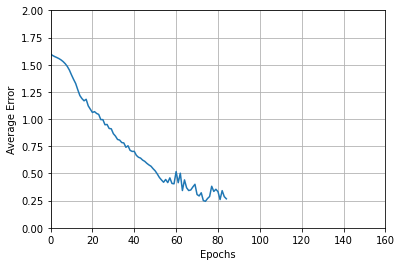

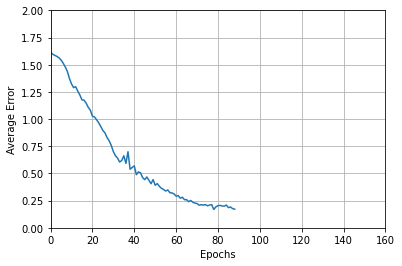

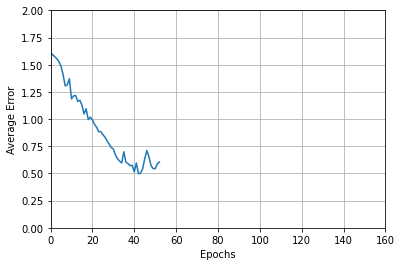

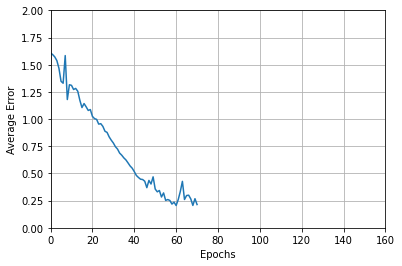

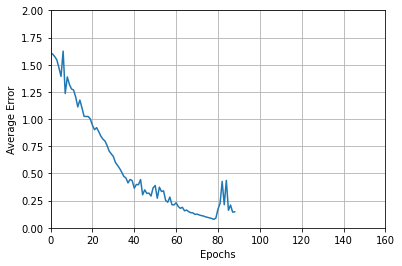

In [19]:
plot_path = 'plotdata/Q1'
for i in range(6):
    df = pd.read_csv(os.path.join(plot_path, f'lstm{i+1}.csv'), usecols=['Step', 'Value'])
    #plt.title(f'arch{i+1}')
    plt.plot(df.Step, df.Value)
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Average Error')
    plt.xlim([0, 160])
    plt.ylim([0, 2])
    plt.show()

In [54]:
print('LSTM')
for i in range(len(rnn_model_archs)):
    model = tf.keras.models.load_model(f'models/Q1/lstm/arch_{i+1}.tf')
    _, acc = model.evaluate(my_tensor,z_train_onehot)   
    print('train acc:', acc)
    _, acc = model.evaluate(test_tensor,z_test_onehot)   
    print('test acc:', acc)
    print('\n\n')

LSTM
11/11 [==============================] - 1s 17ms/step - loss: 0.4145 - accuracy: 0.8421
train acc: 0.8421052694320679
4/4 [==============================] - 0s 11ms/step - loss: 0.3489 - accuracy: 0.7900
test acc: 0.7900000214576721



11/11 [==============================] - 1s 43ms/step - loss: 0.2566 - accuracy: 0.9123
train acc: 0.9122806787490845
4/4 [==============================] - 0s 26ms/step - loss: 0.1799 - accuracy: 0.9500
test acc: 0.949999988079071



11/11 [==============================] - 2s 87ms/step - loss: 0.1681 - accuracy: 0.9503
train acc: 0.9502924084663391
4/4 [==============================] - 0s 54ms/step - loss: 0.1066 - accuracy: 0.9500
test acc: 0.949999988079071



11/11 [==============================] - 3s 190ms/step - loss: 0.5644 - accuracy: 0.8129
train acc: 0.8128654956817627
4/4 [==============================] - 1s 115ms/step - loss: 0.3827 - accuracy: 0.8600
test acc: 0.8600000143051147



11/11 [==============================] - 4s 257ms/s

4/4 [==============================] - 1s 49ms/step


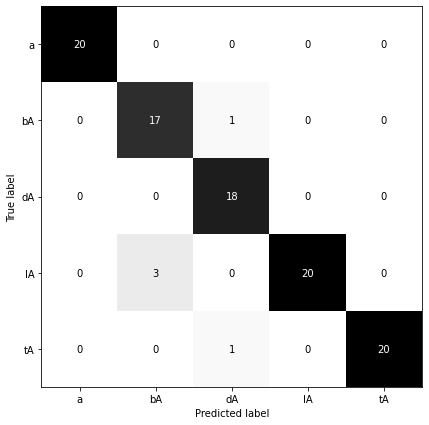

In [68]:
best_arch = 3
model = tf.keras.models.load_model(f'models/Q1/lstm/arch_{best_arch}.tf')
pred = np.argmax(model.predict(test_tensor), axis=1)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(pred, np.argmax(z_test_onehot, axis=1)), display_labels=chars)
cm_display.plot(ax = ax, cmap='Greys', colorbar=False)
plt.show()